In [24]:
import os, sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
from tqdm import *
import matplotlib as mpl
import matplotlib
import matplotlib.pylab as pylab
from cycler import cycler
import palettable
from astropy.cosmology import Planck15
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.misc import derivative
from scipy.optimize import minimize
from scipy.special import erfc
from classy import Class

sys.path.append('/Users/smsharma/heptools/colossus/')

from colossus.cosmology import cosmology
from colossus.lss import mass_function

from theory.spec_calc import PowerSpectra, PowerSpectraPopulations
from theory.astrometry_forecast import Parameter, AstrometryObservation, FisherForecast
from theory.kink import MassFunctionKink, Sigma
from theory.units import *

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from plot_params import params

alpha_global = 0.8
pylab.rcParams.update(params)
plots_dir = "/Users/smsharma/Dropbox/Projects/LensPowerSpectra/LensPower/Draft/plots/"

save_figs = True

cols = ['grey', 'firebrick', 'cornflowerblue'] # + palettable.wesanderson.FantasticFox2_5.hex_colors
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


## Fig. 10: kinked primordial/matter power spectra and halo mass function

Analyze cluster runs.

In [3]:
def P(k, k_B, n_B, n_s=0.9665, A_s=2.105 / 1e9, k_0=0.05) :
    if k < k_B:
        return A_s * (k / k_0) ** (n_s - 1)
    else:
        return A_s * (k_B /k_0) ** (n_s - 1) * (k / k_B) ** (n_B - 1)


In [4]:
n_B_ary = np.linspace(1, 3, 11)
k_B_ary = np.logspace(np.log10(5), np.log10(50), 11)

print(n_B_ary)
print(k_B_ary)

[1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3. ]
[ 5.          6.29462706  7.92446596  9.97631157 12.55943216 15.8113883
 19.90535853 25.05936168 31.54786722 39.71641174 50.        ]


In [5]:
k_B_plot_ary = [k_B_ary[-1], k_B_ary[4], k_B_ary[4]]
n_B_plot_ary = [n_B_ary[0], 2., 3.]
M_min = 1e1

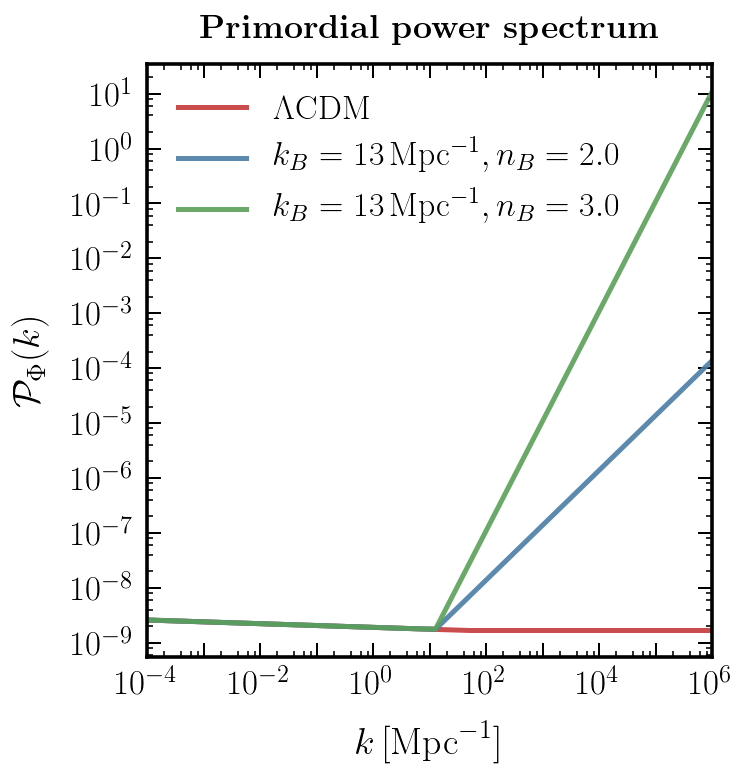

In [26]:
mpl.rcParams['figure.figsize'] = 5.3, 5.5
    
fig, ax = plt.subplots()

k_ary = np.logspace(-4, 6)
for i, (k_B, n_B) in enumerate(zip(k_B_plot_ary, n_B_plot_ary)):
    Pk_ary = [P(k, k_B, n_B) for k in k_ary]
    label = '$k_B = ' + str(round(k_B))[:2] + '$\,Mpc$^{-1}, n_B = ' + str(n_B) + '$'
    if n_B == 1.: label = "$\Lambda$CDM"
    plt.plot(k_ary, Pk_ary, label= label)
    
plt.xscale("log")
plt.yscale("log")

plt.xlabel("$k\,[\mathrm{Mpc}^{-1}]$")
plt.ylabel("$\mathcal P_\Phi(k)$")

plt.xlim(min(k_ary), max(k_ary))

plt.title('\\textbf{Primordial power spectrum}', y = 1.02, fontsize=17)

plt.legend()

# Tick tweaks 

locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)

locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax.yaxis.set_major_locator(locmaj)

locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 1:
        label.set_visible(False)

plt.tight_layout()
plt.savefig(plots_dir + "primordial_kinked.pdf")

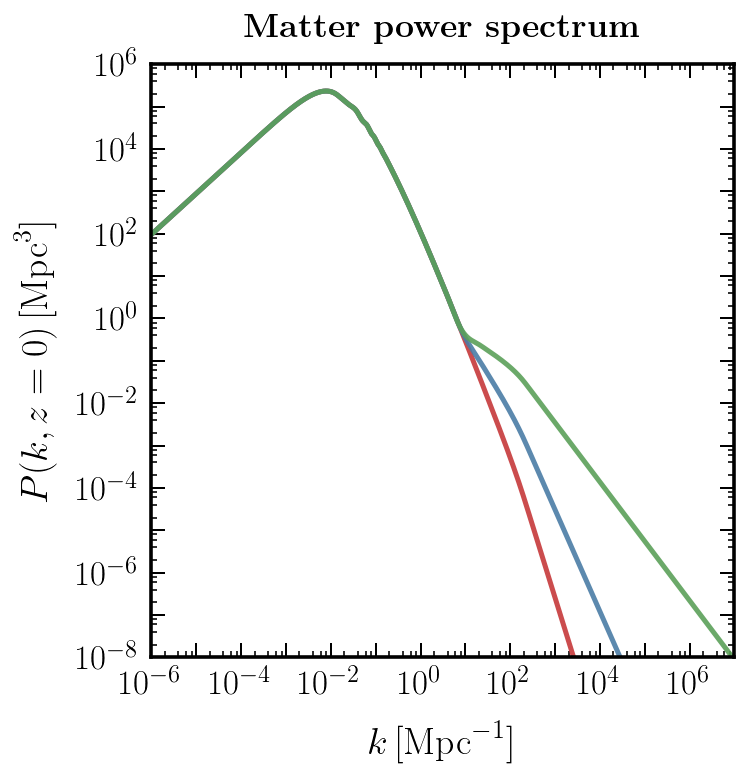

In [48]:
mpl.rcParams['figure.figsize'] = 5.3, 5.5

fig, ax = plt.subplots()

for i, (k_B, n_B) in enumerate(zip(k_B_plot_ary, n_B_plot_ary)):

    filename = "../data/arrays/pk/pk" + str(k_B) + "_" + str(n_B) + "_" + str(M_min) +  ".dat"
    npz = np.loadtxt(filename)

    plt.plot(10 ** npz[:,0], 10 ** npz[:,1])
    plt.xscale("log")
    plt.yscale("log")
    
plt.xlim(1e-6,10 ** 7)
plt.ylim(1e-8,1e6)

plt.xlabel("$k\,[\mathrm{Mpc}^{-1}]$")
plt.ylabel("$ P(k, z=0)\,[\mathrm{Mpc}^3]$")

plt.title('\\textbf{Matter power spectrum}', y = 1.02, fontsize=17)

# Tick tweaks 

locmaj = matplotlib.ticker.LogLocator(base=10,numticks=24) 
ax.xaxis.set_major_locator(locmaj)

locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=14)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

locmaj = matplotlib.ticker.LogLocator(base=10,numticks=24) 
ax.yaxis.set_major_locator(locmaj)

locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=14)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 1:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 1:
        label.set_visible(False)


plt.tight_layout()
plt.savefig(plots_dir + "matterpower_kinked.pdf")

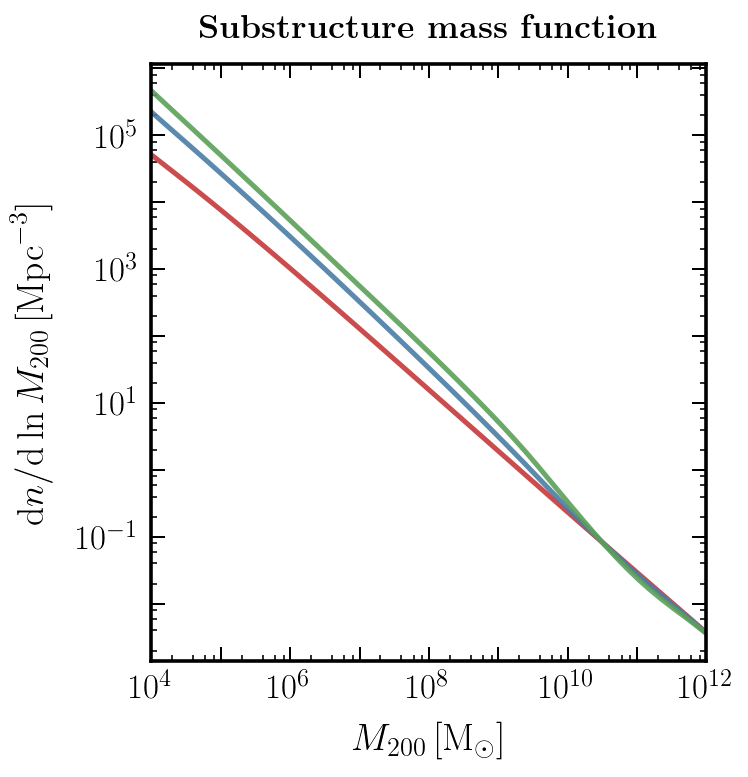

In [49]:
mpl.rcParams['figure.figsize'] = 5.3, 5.5

fig, ax = plt.subplots()

for i, (k_B, n_B) in enumerate(zip(k_B_plot_ary, n_B_plot_ary)):

    filename = "../theory/cluster/cluster_out/calib_" + str(k_B) + "_" + str(n_B) + "_" + str(M_min) +  ".npz"
    npz = np.load(filename)

    plt.plot(npz['M_ary'], npz['dndlnM_ary'])
plt.xscale("log")
plt.yscale("log")
plt.xlim(min(npz['M_ary']), max(npz['M_ary']))

plt.xlabel("$M_{200}\,[\mathrm M_\odot]$")
plt.ylabel("$\mathrm{d}n/\mathrm{d}\ln M_{200}\,[\mathrm{Mpc}^{-3}]$")

plt.title('\\textbf{Substructure mass function}', y = 1.02, fontsize=17)

# Tick tweaks 

locmaj = matplotlib.ticker.LogLocator(base=10,numticks=24) 
ax.xaxis.set_major_locator(locmaj)

locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=14)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

locmaj = matplotlib.ticker.LogLocator(base=10,numticks=24) 
ax.yaxis.set_major_locator(locmaj)

locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=14)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 1:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 1:
        label.set_visible(False)


plt.tight_layout()
plt.savefig(plots_dir + "massfunction_kinked.pdf")

## Fig. 11: sensitivity to kinks

In [9]:
# M_min = 1e1
n_B_ary = np.linspace(1, 3, 11)
k_B_ary = np.logspace(np.log10(5), np.log10(50), 11)

sens_ska_ary = np.zeros((len(n_B_ary), len(k_B_ary)))
sens_wfirst_ary = np.zeros((len(n_B_ary), len(k_B_ary)))
sens_gaia_ary = np.zeros((len(n_B_ary), len(k_B_ary)))

for i_n_B, n_B in enumerate((tqdm_notebook(n_B_ary))):
    for i_k_B, k_B in enumerate((k_B_ary)):
        filename = "../theory/cluster/cluster_out/calib_" + str(k_B) + "_" + str(n_B) + "_" + str(M_min) +  ".npz"
        if not os.path.isfile(filename): continue
        npz = np.load(filename)

        sens_ska_ary[i_n_B, i_k_B] = npz['sig_ska'][0]# get_sens(C_l_mu, C_l_alpha, f_sky=0.05, sigma_mu=10000, sigma_alpha=10, l_max=lmax, l_max_alpha=lmax, l_max_mu=lmax)[1]
        sens_wfirst_ary[i_n_B, i_k_B] = npz['sig_wfirst'][0]# get_sens(C_l_mu, C_l_alpha, f_sky=0.05, sigma_mu=10000, sigma_alpha=10, l_max=lmax, l_max_alpha=lmax, l_max_mu=lmax)[1]
        sens_gaia_ary[i_n_B, i_k_B] = npz['sig_gaia'][0]# get_sens(C_l_mu, C_l_alpha, f_sky=0.05, sigma_mu=10000, sigma_alpha=10, l_max=lmax, l_max_alpha=lmax, l_max_mu=lmax)[1]

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [20]:
mpl.rcParams['figure.figsize'] = 6, 5.5
# fig, ax = plt.subplots()


X, Y = np.meshgrid(np.log10(k_B_ary), n_B_ary)

# plt.contourf(X, Y, sens_ska_ary, levels = [0,1], linestyles=['-'], linewidths=2, alpha=0.05, colors='grey', label='WFIRST-like')
CS1 = plt.contour(X, Y, sens_ska_ary, levels = [1], linestyles=['-'], linewidths=2, alpha=0.8, colors='grey', label='WFIRST-like');

# plt.contourf(X, Y, sens_wfirst_ary, levels = [0,1], linestyles=['-'], linewidths=2, alpha=0.05, colors='firebrick', label='WFIRST-like')
CS2 = plt.contour(X, Y, sens_wfirst_ary, levels = [1], linestyles=['-'],linewidths=2, alpha=0.8, colors='firebrick', label='WFIRST-like');

# plt.contourf(X, Y, sens_gaia_ary, levels = [0,1], linestyles=['-'], linewidths=2, alpha=0.05, colors='cornflowerblue')
CS3 = plt.contour(X, Y, sens_gaia_ary, levels = [1], linestyles=['-'], linewidths=2, alpha=0.8, colors='cornflowerblue');

# ax.clabel(CS1, fmt=fmt1,inline=1, fontsize=15)
# ax.clabel(CS2, fmt=fmt2,inline=1, fontsize=15)
# ax.clabel(CS3, fmt=fmt3,inline=1, fontsize=15)

plt.xlabel("$\log_{10}(k_B\,\mathrm{[Mpc^{-1}]})$")
plt.ylabel("$n_B$")
plt.title('\\textbf{Kinked power spectrum}', fontsize=18)


# labels = ['line1', 'line2','line3']
# for i in range(len(labels)):
#     CS.collections[i].set_label(labels[i])
# CS1.collections[0].set_label("SKA")
# CS2.collections[0].set_label("WFIRST-like")
# CS3.collections[0].set_label("\emph{Gaia}")

# plt.legend(loc='upper left', frameon=False, fancybox=True, framealpha=0.5, ncol=1)

# plt.tight_layout()
# plt.savefig(plots_dir + "kink_PS_sig.pdf")

plt.clf()

/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'label'
  s)
/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'label'
  s)


<Figure size 432x396 with 0 Axes>

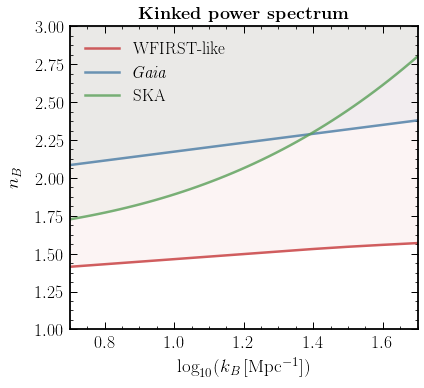

In [21]:
from scipy.interpolate import UnivariateSpline, interp1d
mpl.rcParams['figure.figsize'] = 6, 5.5

x, y = np.transpose(CS2.allsegs[0][0])
x, y = x[::-1][7:], y[::-1][7:]
x_pts = np.linspace(0.7, 1.7)
x, y = x_pts, interp1d(x, y, bounds_error=False, fill_value="extrapolate")(x_pts)
plt.plot(x, y, color=cols_default[0], label='WFIRST-like', alpha=0.8)
plt.fill_between(x, y, 3., color=cols_default[0], alpha=0.05)

x, y = np.transpose(CS3.allsegs[0][0])
x, y = [x[::-1][0], x[::-1][-1]], [y[::-1][0], y[::-1][-1]]
x_pts = np.linspace(0.7, 1.7)
x, y = x_pts, interp1d(x, y, bounds_error=False, fill_value="extrapolate")(x_pts)
plt.plot(x, y, color=cols_default[1], label="\emph{Gaia}", alpha=0.8)
plt.fill_between(x, y, 3., color=cols_default[1], alpha=0.05)

x, y = np.transpose(CS1.allsegs[0][0])
x, y = x[::-1], y[::-1]
x_pts = np.linspace(0.7, 1.7)
x, y = x_pts, UnivariateSpline(x, y, )(x_pts)
plt.plot(x, y, color=cols_default[2], label='SKA', alpha=0.8)
plt.fill_between(x, y, 3., color=cols_default[2], alpha=0.05)


plt.xlim(0.7, 1.7)
plt.ylim(1, 3)

plt.xlabel("$\log_{10}(k_B\,\mathrm{[Mpc^{-1}]})$")
plt.ylabel("$n_B$")
plt.title('\\textbf{Kinked power spectrum}', fontsize=18)

plt.legend()

plt.tight_layout()
plt.savefig(plots_dir + "kink_PS_sig.pdf")